In [1]:
''' development / testing only '''

# set auto reload imported modules tagged
%load_ext autoreload
%autoreload 2


''' Import PVLibs Package '''

# add custom python packages directory to path
import sys
sys.path.append('/home/brendan/dev/packages')

# import pvlibs libraries
import pvlibs


In [2]:
''' Imports '''

# data array processing
import numpy as np
import pandas as pd

# plotting with matplotlib, inline interactive notebook
%matplotlib notebook
from matplotlib import pyplot as plt

# ipython notebook widget display
from IPython.display import display


In [4]:
''' Select Files '''

# generate and display upload widget
w = pvlibs.file_upload_widget()
display(w)


FileUpload(accept='.xlsm, .ltr', multiple=True)

In [24]:
''' Upload Files'''

# upload files to server
pvlibs.file_upload(w)


sphj-init-h2150-gen-1.xlsm uploaded
sphj-init-h2149-gen-1.xlsm uploaded
sphj-init-h2144-gen-1.xlsm uploaded
sphj-init-h2143-gen-1.xlsm uploaded
sphj-init-h2142-gen-1.xlsm uploaded
sphj-init-h2140-gen-1.xlsm uploaded


In [28]:
''' Initialise Database and Batch Prepare Files '''

# initialise database instance
db = []

# define source file properties
props = {
    # set file tags (optional)
    #'device_state_id': 'init',
    
    # set file parsing (required)
    'meas_type': 'slt',
    'file_type': 'xlsm',
    'file_ext': 'xlsm',
    
    # set measurement properties (required)
    'wafer_doping_type': 'n-type',
    'temperature': 298.,
    'wafer_resistivity': 1.8,
    'wafer_thickness': .012,
    'wafer_optical_const': 1.03,
    'illumination_mode': 'gen',
}

# batch prepare source files, recursive search directory and store as nodes in database instance
pvlibs.add_files(db, './upload/', props)

print(len(db))

6


In [29]:
''' Import Sinton-Lifetime Data from File '''

# iterate each node in database
for node in db:
    
    try:
        # get data file properties
        meas_type = node['meas_type']
        file_type = node['file_type']
        file_path = node['file_path']
        file_name = node['file_name']

        # import data from file and store in node
        data = pvlibs.data_import.core.import_data_file(
            meas_type = meas_type,
            file_type = file_type,
            file_path = file_path,
            file_name = file_name,
        )
        for k,v in data.items():
            node[k] = v

        node['data_import'] = True
    
    except:
        print('import failed for {}'.format(node['file_name']))
        
        node['data_import'] = False
        
        pass
    
db = [ d for d in db if d['data_import'] ]
    
print(len(db))

/usr/lib/python3.7/site-packages/openpyxl/packaging/workbook.py:92: UserWarning: File contains an invalid specification for Module1. This will be removed
  warn(msg)


6


In [30]:
''' Parse Properties from File Name'''

#sphj-init-h2149-gen-1.xlsm

# define regular expression for parsing measurement properties from file name (device_id and illumination_mode required)
parse_string = '^(?P<device_id>.+)\..+$'

# iterate each node in database
for node in db:
    
    # extract properties from file name
    filename_params = pvlibs.general.str_parse_params(_string = node['file_name'], _parse_string = parse_string)
    
    # if successful, store properties in node
    if filename_params is not None:
        for k,v in filename_params.items():
            node[k] = v

# remove nodes from database if device_id property not found
db = [ d for d in db if 'device_id' in d.keys() ]

# print total nodes (files) prepared
print(len(db))


6


In [31]:
''' Remove Uploads '''

# clear uploads from server
pvlibs.clear_uploads()


uploads removed


In [32]:
''' Process Sinton-Lifetime Data '''

# iterate each node in database
for node in db:
    
    try:

        # get data file properties
        meas_type = node['meas_type']

        # process data and store results in node
        results = pvlibs.process_data.core.process_data(
            meas_type = meas_type,
            data = node,
        )
        for k,v in results.items():
            node[k] = v
        
        node['data_process'] = True
    
    except:
        print('process failed for {}'.format(node['file_name']))
        
        node['data_process'] = False
        
        pass


db = [ d for d in db if d['data_process'] ]
    
print(len(db))

6


In [33]:
''' Model Injection Dependent Lifetime Data '''

# iterate each node in database
for node in db:
    
    try:
        
        # set charge density range and model to fit
        node['nd_range'] = [1e14, 1e17]
        node['lt_model'] = 'std'

        # run lifetime modelling process, store results in node
        results = pvlibs.process_data.core.process_data(
            meas_type = 'mlt',
            data = node,
        )
        for k,v in results.items():
            node[k] = v
        
        node['data_model'] = True
    
    except:
        print('model failed for {}'.format(node['file_name']))
        
        node['data_model'] = False
        
        pass


#db = [ d for d in db if d['data_process'] ]    
#print(len(db))

<IPython.core.display.Javascript object>


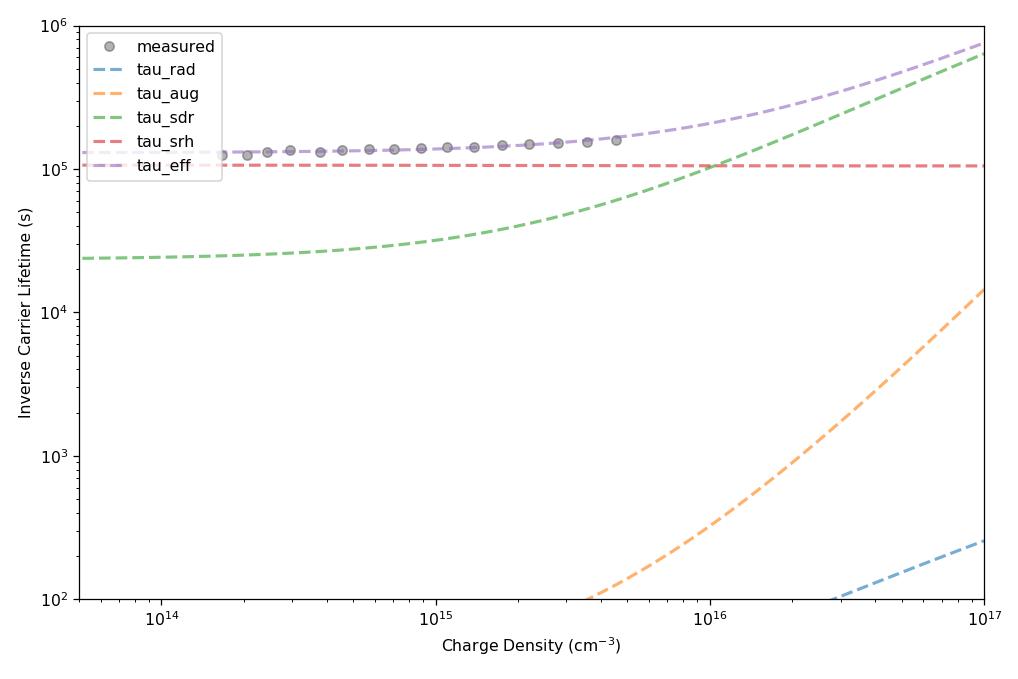

Surface Recombination Velocity (J_0) = 1234.0 [fa]
Bulk Lifetime = 9.5 [us]
Effective Lifetime = 6.8 [us]
Implied Voc = 580.1 [V]
Fit R^2 = 0.85


In [35]:
''' Plot Lifetime Modelling Results '''

# set search / filter properties
#device_id = 'XXX'
#device_state_id = 'init'

# search for single measurement
#_node = [ n for n in db if
#    #n['device_id'] == device_id and
#    n['device_state_id'] == device_state_id
#][0]

_node = db[0]


# initialise figure and axes
fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(111)

ax.set_xlim(5e13, 1e17)
ax.set_ylim(1e2, 1e6)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Charge Density (cm$^{-3}$)')
ax.set_ylabel(r'Inverse Carrier Lifetime (s)')

# plot measured charge density dependent effective lifetime
ax.plot(_node['nd'][::3], _node['tau'][::3]**-1, 'ok', label = 'measured', alpha = 0.3)

# iterate and plot each model component
for name, tau in _node.items():
    if name[:4] == 'tau_':
        
        # plot charge density dependent recombination lifetime component
        ax.plot(_node['dn'], tau**-1 , '--', label = '{}'.format(name), linewidth = 2, alpha = 0.6)

# set figure title
#ax.set_title('Lifetime Modelling [ device: {}, state: {}]'.format(_node['device_id'], _node['device_state_id']))
        
# display figure
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

# print fitting results
print('Surface Recombination Velocity (J_0) = {:.1f} [fa]'.format(_node['J_0']*1e15))
print('Bulk Lifetime = {:.1f} [us]'.format(_node['t_blk']*1e6))
print('Effective Lifetime = {:.1f} [us]'.format(_node['t_eff']*1e6))
print('Implied Voc = {:.1f} [V]'.format(_node['ivoc']*1e3))
print('Fit R^2 = {:.2f}'.format(_node['R2']))


In [36]:
''' Compile Data for Export '''

# set labels and values to export, update names
#labels = {'device_id': 'Device', 'device_state_id': 'State', 'wafer_region': 'Region'}
labels = {'device_id': 'Device', }
values = {'ivoc': 'iVoc (V)', 'J_0': 'J_0 (A)', 't_blk': 't_Blk (s)', 't_eff': 't_Eff (s)', 'R2': 'R^2', }

## aggregate results from nodes in database
data = {**{ v:[] for k,v in labels.items() }, **{ v:[] for k,v in values.items() } }
for node in db:
    # store labels
    for k,v in labels.items():
        data[v].append( node[k] )
    # store values
    for k,v in values.items():
        data[v].append( node[k] )

# store values in pandas dataframe
data = pd.DataFrame(data)

# display averages
#data.groupby(['State', 'Device', 'Region']).mean()
data.groupby(['Device']).mean()


,iVoc (V),J_0 (A),t_Blk (s),t_Eff (s),R^2
Device,,,,,
sphj-init-h2140-gen-1,0.582309,1.167719e-12,0.000010,0.000007,0.867087
sphj-init-h2142-gen-1,0.582837,1.087901e-12,0.000010,0.000007,0.825030
sphj-init-h2143-gen-1,0.583418,1.107551e-12,0.000011,0.000008,0.790412
sphj-init-h2144-gen-1,0.579605,1.431696e-12,0.000009,0.000007,0.831282
sphj-init-h2149-gen-1,0.583036,1.064102e-12,0.000010,0.000008,0.849418
sphj-init-h2150-gen-1,0.580058,1.233990e-12,0.000009,0.000007,0.849229


In [39]:
''' Export Summary Results '''

# save summary data to csv file
data.to_csv('./results/lt-summary.csv', index = False)
